In [1]:
from IPython.display import display
import pandas as pd
import altair as alt
from altair.utils.data import to_values

def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

In [2]:
ports = ['Marseille',
'Le Havre',
'Dunkerque',
'Rouen',
'Bordeaux',
'Boulogne-sur-Mer',
'Marennes',
'Cap-Français',
'Nantes',
'La Rochelle',
'Saint-Malo',
'Toulon',
'Dieppe',
'Lorient',
'Honfleur',
'Marans',
'Sète',
'Bayonne',
'Tonnay-Charente',
'Arles']

In [16]:
import csv
with open('../../data/toflit18_all_flows.csv') as f:
    reader = csv.DictReader(f)
#     customs_region_pos = reader.headers['customs_region']
#     value_pos = reader.headers['value']
#     partner_pos = reader.headers['partner_grouping']
    list_of_regions_values = []
    for row in reader:
        if row['customs_region'] \
        and row['partner_grouping'] != 'France' \
        and row['year'] == '1789'\
        and row['export_import'] == 'Imports'\
        and row['best_guess_region_prodxpart'] =='1':
            list_of_regions_values.append(row)

In [17]:
values_per_customs_region = {}

for i in list_of_regions_values:
    if i['value']:
        if not i['customs_region'] in values_per_customs_region:
            values_per_customs_region[i['customs_region']] = 0
        values_per_customs_region[i['customs_region']] += float(i['value'])

In [13]:
values_per_customs_region

{'Amiens': 3610793.6956379474,
 'Auch': 2145359.3009015005,
 'Bayonne': 16653122.977829149,
 'Besançon': 16182680.233392753,
 'Bordeaux': 131582196.8769541,
 'Caen': 502370.94720339996,
 'Charleville': 2265570.115926632,
 'Châlons': 6407065.968854733,
 'Directions de terre': 607756.0,
 'Flandre': 10951606.0,
 'France': 1388076.0,
 'Grenoble': 15873853.45344538,
 'La Rochelle': 13334295.937960692,
 'Langres': 477352.30000000005,
 'Lorient': 2736414.64403617,
 'Lyon': 3296029.8279999997,
 'Marseille': 82122895.1804797,
 'Montpellier': 7423987.9590612035,
 'Nantes': 43446843.15019201,
 'Narbonne': 1167178.52401036,
 'Rouen': 42264843.0,
 'Saint-Malo': 6393802.211436911,
 'Saint-Quentin': 5217.0,
 'Soisson': 23897.0,
 'Toulon': 2270502.6090725833,
 'Valenciennes': 4655819.0}

In [18]:
data = [{'customs_region':k, 'value':v} for k,v in values_per_customs_region.items()]

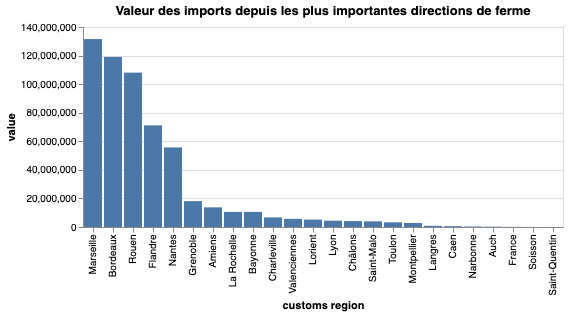

In [20]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Valeur des imports depuis les plus importantes directions de ferme",
    "mark": "bar",
    "data": {
        "values": data
    },
    "encoding": {
        "y": {
            "field": "value",
            "type": "quantitative", 
            "title": "value"
        },
        "x": {
            "field": "customs_region",
            "type": "nominal",
            "title": "customs region",
            "sort": "-y"
        }
    }
})